<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/qmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/fagonzalezo/qmc.git
else:
    import sys
    sys.path.insert(0, "../")

In [2]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models


63/63 [==============================] - 0s 461us/step
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all

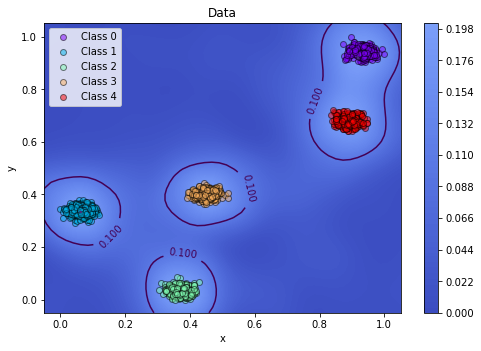

In [4]:
X, y = make_blobs(n_samples=2000, n_features=2, centers=5, cluster_std=0.2, random_state=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
fm_x = layers.QFeatureMapRFF(2, dim=100, gamma=25, random_state=17)
qmd = models.QMDensity(fm_x, 100)
# out = qmd(X[:2,:])
qmd.compile()
qmd.fit(X, epochs=1)
out = qmd.predict(X)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd.predict)
plot_data(X, y)

5.9852013e-05 5.9852013e-05


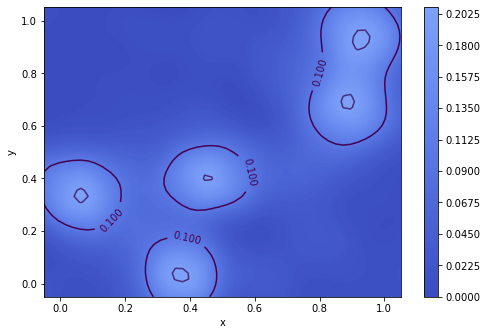

In [5]:
qmd1 = models.QMDensitySGD(2, 100, num_eig= 5, gamma=25, random_state=17)
out = qmd1(X[:2,:])
eig_vals = qmd1.set_rho(qmd.weights[2])
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd1.predict)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999999>

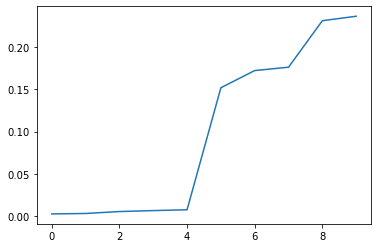

In [6]:
pl.plot(eig_vals[-10:])
tf.reduce_sum(eig_vals)

2.3923055e-09 2.3923055e-09


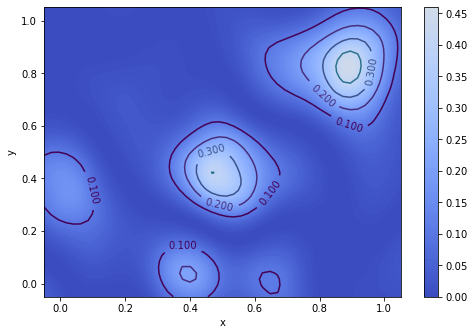

In [7]:
idx = 4
eig_vec = qmd1.weights[2][:,idx:idx+1]
rho = tf.matmul(eig_vec, tf.transpose(eig_vec, conjugate=True))
qmd2 = models.QMDensitySGD(2, 100, num_eig= 1, gamma=25, random_state=17)
#out = qmd2(X[:2,:])
qmd2.set_rho(rho)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd2.predict)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmd3 = models.QMDensitySGD(2, 100, num_eig=5, gamma=25, random_state=17)
#out = qmd3(X[:2,:])
qmd3.compile(optimizer)
eig_vals = qmd3.set_rho(qmd.weights[2])
qmd3.fit(X, epochs=5)

Epoch 1/5
63/63 [==============================] - 0s 471us/step - loss: 47.1936
Epoch 2/5
63/63 [==============================] - 0s 500us/step - loss: 32.1632
Epoch 3/5
63/63 [==============================] - 0s 498us/step - loss: 29.0156
Epoch 4/5
63/63 [==============================] - 0s 496us/step - loss: 27.1671
Epoch 5/5
63/63 [==============================] - 0s 489us/step - loss: 23.1304


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

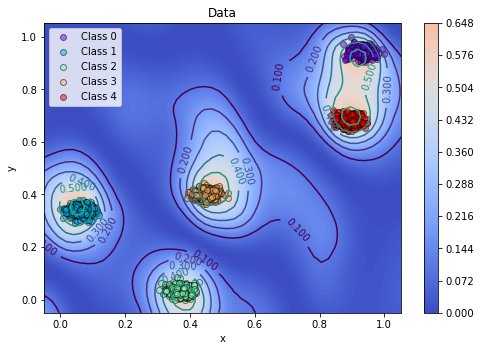

In [9]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd3.predict)
plot_data(X, y)

In [10]:
qmd3.weights[3]

<tf.Variable 'eig_val:0' shape=(5,) dtype=float32, numpy=
array([-0.05490169, -0.06440755, -0.06729024, -0.07862911,  0.6149961 ],
      dtype=float32)>

In [11]:
norms = tf.expand_dims(tf.linalg.norm(qmd3.weights[2], axis=0), axis=0)
eig_vec = qmd3.weights[2] / norms
eig_val = tf.keras.activations.relu(qmd3.weights[3])
eig_val = eig_val / tf.reduce_sum(eig_val)
rho_h = tf.matmul(eig_vec,
                    tf.linalg.diag(tf.sqrt(eig_val)))
rho = tf.matmul(
    rho_h,
    tf.transpose(rho_h, conjugate=True))

In [12]:
rho

<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[ 6.8822515e-04,  6.2473683e-04, -4.3844497e-03, ...,
         6.2374071e-05,  1.2632182e-03,  5.7875586e-04],
       [ 6.2473683e-04,  5.6710525e-04, -3.9799870e-03, ...,
         5.6620105e-05,  1.1466872e-03,  5.2536605e-04],
       [-4.3844497e-03, -3.9799870e-03,  2.7931847e-02, ...,
        -3.9736411e-04, -8.0475360e-03, -3.6870579e-03],
       ...,
       [ 6.2374071e-05,  5.6620105e-05, -3.9736411e-04, ...,
         5.6529825e-06,  1.1448588e-04,  5.2452833e-05],
       [ 1.2632182e-03,  1.1466872e-03, -8.0475360e-03, ...,
         1.1448588e-04,  2.3186021e-03,  1.0622904e-03],
       [ 5.7875586e-04,  5.2536605e-04, -3.6870579e-03, ...,
         5.2452833e-05,  1.0622904e-03,  4.8669879e-04]], dtype=float32)>